<a href="https://colab.research.google.com/github/bathaee/tensorflow-deep-learning/blob/main/Marzieh_GAN_cifer10_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

from matplotlib import pyplot as plt

170498071/170498071 [==============================] - 4s 0us/step


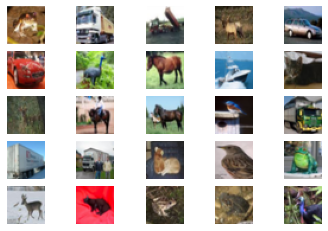

In [2]:
from keras.datasets.cifar10 import load_data
(trainx,trainy), (testx,testy) = load_data()
# plot 25 images
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(trainx[i])
plt.show()

In [3]:
trainx.shape,trainy.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
# Function related to the Discriminator's network
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

#2. Compile the model for discriminator
  model.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate=0.0002,beta_1=0.5), 
                metrics = ['accuracy'])
  return model

D =  define_discriminator(in_shape=(32,32,3))
print(D.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

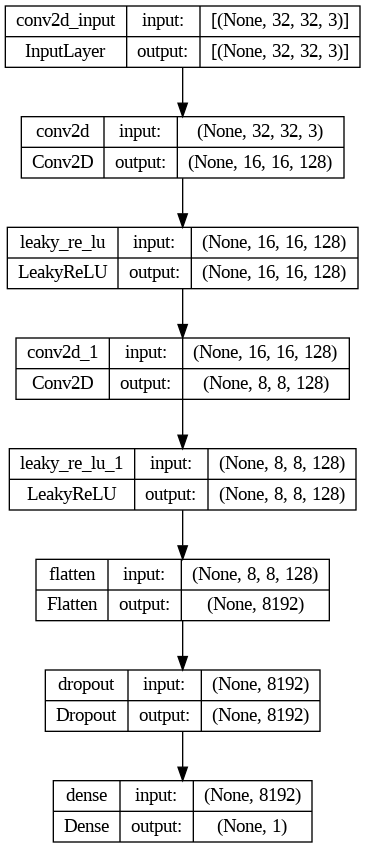

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model=D, show_shapes=True)

In [6]:
# Function related to the Generator's network
def define_generator(latent_dim):
  n_nodes = 8*8*128
  model = Sequential()
  model.add(Dense(n_nodes,input_dim=latent_dim,activation = LeakyReLU(alpha=0.2)))
  model.add(Reshape((8,8,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation = LeakyReLU(alpha=0.2)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same',activation= LeakyReLU(alpha=0.2)))
  model.add(Conv2D(3,(8,8),padding='same',activation='tanh'))
  return model

G = define_generator(100)
print(G.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 3)         24579     
                                                                 
Total params: 1,376,515
Trainable params: 1,376,515
No

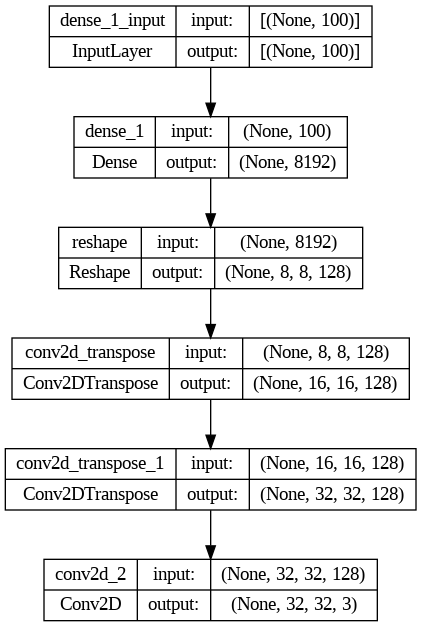

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model=G, show_shapes=True)

In [8]:
# GAN-Combined 
# Define the combined generator and discriminator model, for updating the generator 
# Discriminator is trained separately so here only generator will be trained by keeping discriminator constant.

def define_gan(generator,discriminator):
  discriminator.trainable = False #discriminator is trained separately.
  # connect generator and discriminator
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  #compile model
  model.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=0.0002,beta_1=0.5), 
                metrics=['accuracy'])
  return model

GAN =   define_gan(G,D)
print(GAN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1376515   
                                                                 
 sequential (Sequential)     (None, 1)                 159361    
                                                                 
Total params: 1,535,876
Trainable params: 1,376,515
Non-trainable params: 159,361
_________________________________________________________________
None


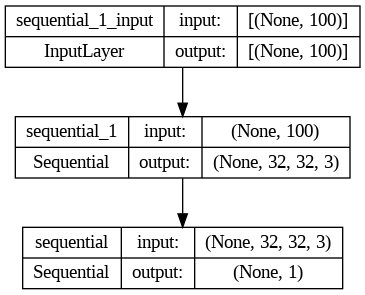

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model=GAN, show_shapes=True)

In [10]:
def load_real_samples():
  (trainx, _),(_,_) = load_data()
  x = trainx.astype('float32')
  x = (x-127.5)/127.5 #scale -1 to 1
  return x
# real samples
def generate_real_samples(dataset,n_samples):
  ix = randint(0,dataset.shape[0],n_samples)
  x=dataset[ix]
  y= ones((n_samples,1))#label=1 indicating they are real
  return x,y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim,n_samples):
  x_input = randn(latent_dim*n_samples) #generate points in the latent space
  x_input = x_input.reshape(n_samples,latent_dim) 
  return x_input 

# fake samples  
def generate_fake_samples(generator,latent_dim,n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  x = generator.predict(x_input)
  y= zeros((n_samples,1))# label = 0 indicating they are fake
  return x, y

In [11]:
x1 = load_real_samples()
datasets = load_real_samples()
x2 = generate_real_samples(datasets,2)
x3 = generate_latent_points(100,2)

x1.shape,x3.shape,x2[0].shape

((50000, 32, 32, 3), (2, 100), (2, 32, 32, 3))

In [12]:
# The GAN training process-training code
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs,n_batch=10000):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  #The discriminator model is updated for a half batch of real samples and a half batch of facke samples, combined a single batch.
  for i in range(n_epochs):# Enumerate epochs
    for j in range(bat_per_epo):# Enumerate batches
      x_real,y_real = generate_real_samples(dataset,half_batch) #Get some real images
      d_loss_real, _= d_model.train_on_batch(x_real,y_real) # update D weights on real images
      x_fake, y_fake = generate_fake_samples(g_model,latent_dim,half_batch) # Get fake images
      d_loss_fake, _ = d_model.train_on_batch(x_fake,y_fake) # update D weights on fake images

      x_gan = generate_latent_points(latent_dim,n_batch) #input for the generator
      y_gan = ones((n_batch,1)) #Label generated images as true to trick the discriminator

      g_loss = gan_model.train_on_batch(x_gan,y_gan) # train the generator with
      #print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
      # save the generator model
  g_model.save('cifar_generator_2epochs.h5')

In [ ]:
# Train the GAN

latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator,discriminator)
dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

157/157 [==============================] - 69s 437ms/step


In [ ]:
import numpy as np
from keras.models import load_model
#plot generated image
def show_plot(examples,n):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,:])
  plt.show()  

#load model
model = load_model('cifer_generator_250epochs.h5')
latent_points = generate_latent_points(100,25)
x = model.predict(latent_points)
x = (x+1)/2
x=(x*255).astype(np.unit8)

show_plot(x,5)